In [4]:
import numpy as np
import pandas as pd
import torch

import matplotlib.pyplot as plt
%matplotlib inline

DEVICE = 'cuda'

# 1. Import Dataset

In [6]:
from torch.utils.data import DataLoader
from poc_data_v2 import PocDataset, custom_collate_fn, display_sample


NUM_CASES = 2**8
BATCH_SIZE = 2**4

poc_raw_dataset = PocDataset(num_cases=NUM_CASES)
data_loader = DataLoader(dataset=poc_raw_dataset,
                        batch_size=BATCH_SIZE,
                        shuffle=False,
                        collate_fn=custom_collate_fn,
                        pin_memory=True)

batch, event = next(iter(data_loader))

print(len(batch))
print(len(event))

16
16


### Data Exploration

Event is 0, Length is 36
Event is 0, Length is 36
Event is 0, Length is 26
Event is 0, Length is 34
Event is 2, Length is 11


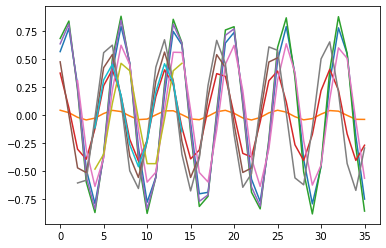

In [23]:
#Take a look at the longitudional data
display_sample((batch[0],event[0]))
display_sample((batch[1],event[1]))
display_sample((batch[2],event[2]))
display_sample((batch[3],event[3]))
display_sample((batch[4],event[4]))

### Test Sample

Event is 0, Length is 36


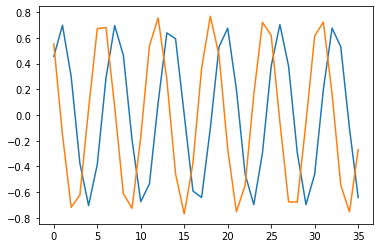

In [35]:
test_poc_raw_dataset = PocDataset(num_cases=1)
test_data_loader = DataLoader(dataset=test_poc_raw_dataset,batch_size=1,collate_fn=custom_collate_fn,pin_memory=True)
test_batch, test_event = next(iter(test_data_loader))

display_sample((test_batch[0], test_event[0]))

# 2. Hyperparameters

In [ ]:
from torch.nn import MSELoss
from tqdm import trange, tqdm

from torch.optim import Adam
from torch.utils.tensorboard import SummaryWriter

from dynamicDeepHit import EncoderRNN, AttnDecoderRNN, CauseSpecificSubnetwork, DynamicDeepHit
from losses import loss_1_batch, loss_2_batch, loss_3_batch

NUM_EPOCHS = 10

LEARNING_RATE_ENCODER = 0.0001
LEARNING_RATE_DECODER = 0.0001
LEARNING_RATE_CAUSESS = 0.00005

LOSS_1_AMPLIFIER = 1
LOSS_2_AMPLIFIER = 1
LOSS_3_AMPLIFIER = 1

RUN_VALIDATION_ROUND = False
VAL_NUM_CASES_RUNTIME = 2**3

input_size = 5
output_size = input_size
MAX_LENGTH = 36
NUM_CAUSES = 3
hidden_size_encoder = 512
hidden_size_attenti = 512
fc_size_encoder = 512
SIGMA = 1

# 3. Defining The Model

In [ ]:
# initialize model
encoder = EncoderRNN(input_size, hidden_size_encoder, fc_size_encoder).to(DEVICE)
decoder = AttnDecoderRNN(hidden_size_encoder, hidden_size_attenti, output_size).to(DEVICE)
causess = CauseSpecificSubnetwork(hidden_size_encoder, input_size, MAX_LENGTH, NUM_CAUSES).to(DEVICE)
DDHT = DynamicDeepHit(encoder, decoder, causess, MAX_LENGTH, DEVICE)

# intialize optimizer
optimizer_encoder = Adam(encoder.parameters(), lr=LEARNING_RATE_ENCODER)
optimizer_decoder = Adam(decoder.parameters(), lr=LEARNING_RATE_DECODER)
optimizer_causess = Adam(causess.parameters(), lr=LEARNING_RATE_CAUSESS)
 
# initialize loss
writer = SummaryWriter()

# 4. Training the model

In [ ]:
from torch import autograd

# start training
for epoch in trange(NUM_EPOCHS):

  epoch_loss = 0

  for batch_number, data in enumerate(data_loader):

    batch_loss = 0

    optimizer_encoder.zero_grad()
    optimizer_decoder.zero_grad()
    optimizer_causess.zero_grad()

    input_batch, event_batch, time_to_event_batch, _ = data
    input_batch = input_batch.to(DEVICE)
    event_batch = event_batch.to(DEVICE)
    time_to_event_batch = time_to_event_batch.to(DEVICE)

    output_batch, first_hitting_time_batch = DDHT(input_batch, time_to_event_batch)

    loss1 = loss_1_batch(first_hitting_time_batch, event_batch, time_to_event_batch, MAX_LENGTH)
    loss2 = loss_2_batch(first_hitting_time_batch, event_batch, time_to_event_batch, NUM_CAUSES, MAX_LENGTH, SIGMA, DEVICE)
    loss3 = loss_3_batch(output_batch, input_batch.detach())

    batch_loss = loss1 + loss2 + loss3
    batch_loss.backward()

    epoch_loss += batch_loss.detach()

    writer.add_scalar('train_loss1', loss1.item(), epoch*len(data_loader) + batch_number)
    writer.add_scalar('train_loss2', loss2.item(), epoch*len(data_loader) + batch_number)
    writer.add_scalar('train_loss3', loss3.item(), epoch*len(data_loader) + batch_number)

    optimizer_encoder.step()
    optimizer_decoder.step()
    optimizer_causess.step()

  if RUN_VALIDATION_ROUND:
    # validating round
    DDHT.eval()

    with torch.no_grad():
      val_poc_raw_dataset = PocDataset(num_cases=VAL_NUM_CASES_RUNTIME)
      val_data_loader = torch.utils.data.DataLoader(val_poc_raw_dataset,batch_size=VAL_NUM_CASES_RUNTIME)
      val_input_batch, val_event_batch, val_time_to_event_batch, _ = next(iter(val_data_loader))
      val_input_batch = val_input_batch.to(DEVICE)
      val_event_batch = val_event_batch.to(DEVICE)
      val_time_to_event_batch = val_time_to_event_batch.to(DEVICE)

      val_output_batch, val_first_hitting_time_batch = DDHT(val_input_batch, val_time_to_event_batch)

      val_loss1 = loss_1_batch(val_first_hitting_time_batch, val_event_batch, val_time_to_event_batch, MAX_LENGTH)/VAL_NUM_CASES_RUNTIME
      val_loss2 = loss_2_batch(val_first_hitting_time_batch, val_event_batch, val_time_to_event_batch, NUM_CAUSES, MAX_LENGTH, SIGMA, DEVICE)/VAL_NUM_CASES_RUNTIME
      val_loss3 = loss_3_batch(val_output_batch, val_input_batch.detach())/VAL_NUM_CASES_RUNTIME

      writer.add_scalar('val_loss1', val_loss1.item(), epoch)
      writer.add_scalar('val_loss2', val_loss2.item(), epoch)
      writer.add_scalar('val_loss3', val_loss3.item(), epoch)
      writer.add_scalar('val_epoch_loss', val_loss1.item() + val_loss2.item() + val_loss3.item(), epoch)

    DDHT.train()
    # end validating round

  writer.add_scalar('train_epoch_loss', epoch_loss.item(), epoch)
  


# 4. Testing the Model

### Predicting the test sample

In [ ]:
PATH = "C:/Users/marij/Desktop/THESIS ECO/DDHT/DDHT_pytorch/models/model_3.pth"
DDHT.load_state_dict(torch.load(PATH))

In [ ]:
DDHT.eval()
print("event=%d, time_to_event=%d, latent_variable=%f" % (test_event.item(), test_time_to_event.item(), test_latent_variable.item()))
print(test_batch)
test_encoder_output_vector, test_first_hitting_time = DDHT(test_batch, test_time_to_event)
print(test_encoder_output_vector)

In [ ]:
print("event=%d, time_to_event=%d, latent_variable=%f" % (test_event.item(), test_time_to_event.item(), test_latent_variable.item()))
print(test_batch)
test_encoder_output_vector, test_first_hitting_time = DDHT(test_batch, test_time_to_event)
print(test_encoder_output_vector)
print(torch.round(test_first_hitting_time * 10**2) / (10**2))
print(test_first_hitting_time.argmax())

In [ ]:
fig, (ax1, ax2) = plt.subplots(2)
ax1.bar([i for i in range(MAX_LENGTH)], test_first_hitting_time.squeeze()[:MAX_LENGTH].cpu().detach().numpy())
ax2.bar([i for i in range(MAX_LENGTH)], test_first_hitting_time.squeeze()[MAX_LENGTH:].cpu().detach().numpy())
ax1.set_title("event 1")
ax2.set_title("event 2")
ax1.set_ylim([0,1]);
ax2.set_ylim([0,1]);

In [ ]:
fig, (ax1, ax2) = plt.subplots(2)
ax1.bar([i for i in range(MAX_LENGTH)], torch.cumsum(test_first_hitting_time.squeeze()[:MAX_LENGTH], dim=0).cpu().detach().numpy())
ax2.bar([i for i in range(MAX_LENGTH)], torch.cumsum(test_first_hitting_time.squeeze()[MAX_LENGTH:], dim=0).cpu().detach().numpy())
ax1.set_title("event 1")
ax2.set_title("event 2")
ax1.set_ylim([0,1]);
ax2.set_ylim([0,1]);

### Scoring our model

In [ ]:
from poc_data import PocDataset

VAL_NUM_CASES = 2**6

val_poc_raw_dataset = PocDataset(num_cases=VAL_NUM_CASES)
val_data_loader = torch.utils.data.DataLoader(val_poc_raw_dataset,batch_size=2**6)
val_input_batch, val_event_batch, val_time_to_event_batch, _ = next(iter(val_data_loader))
val_input_batch = val_input_batch.to(DEVICE)
val_event_batch = val_event_batch.to(DEVICE)
val_time_to_event_batch = val_time_to_event_batch.to(DEVICE)


In [ ]:
DDHT.eval()

val_output_batch, val_first_hitting_time_batch = DDHT(val_input_batch, val_time_to_event_batch)
val_loss1 = loss_1_batch(val_first_hitting_time_batch, val_event_batch, val_time_to_event_batch, MAX_LENGTH)/VAL_NUM_CASES
val_loss2 = loss_2_batch(val_first_hitting_time_batch, val_event_batch, val_time_to_event_batch, NUM_CAUSES, MAX_LENGTH, SIGMA, DEVICE)/VAL_NUM_CASES
val_loss3 = loss_3_batch(val_output_batch, val_input_batch.detach())/VAL_NUM_CASES


print("val_loss1=", val_loss1.item())
print("val_loss2=", val_loss2.item())
print("val_loss3=", val_loss3.item())


Records:
val_loss1= 0.09860126674175262
val_loss2= 16.080060958862305
val_loss3= 690.994384765625

In [ ]:
PATH = "C:/Users/marij/Desktop/THESIS ECO/DDHT/DDHT_pytorch/models/model_3.pth"
torch.save(DDHT.state_dict(), PATH)